In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/dualclass.zip
!unzip -q dataset/test2classes.zip

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Here I have used Alexnet architecture pre-trained on Imagenet Dataset

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        from torchvision import models
        # downloading pretrained model from torchvision
        alexnet = models.alexnet(pretrained=True)
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = alexnet.classifier
        self.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 1000 # We use a small batch size here for training
batch_size_test = 100 #
batch_size_val = 100

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('dualclass/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


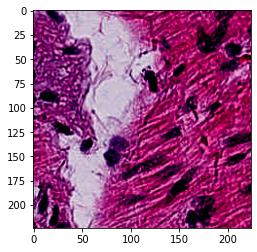

In [ ]:
# import library
import matplotlib.pyplot as plt
# Checking the data loader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# showing random image from dataloader
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = AlexNet(2).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("AlexNet2SGD.pth"):
        os.remove("AlexNet2SGD.pth")
      torch.save(model.state_dict(), 'AlexNet2SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = AlexNet(2).to(device)
  model.load_state_dict(torch.load('AlexNet2SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

1


<ipython-input-8-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.4561

Test: Average loss: 0.2078, Accuracy: 8340/9096 (91.69%)

2


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1965

Test: Average loss: 0.1479, Accuracy: 8599/9096 (94.54%)

3


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1553

Test: Average loss: 0.1192, Accuracy: 8697/9096 (95.61%)

4


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1330

Test: Average loss: 0.1092, Accuracy: 8716/9096 (95.82%)

5


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1233

Test: Average loss: 0.0983, Accuracy: 8766/9096 (96.37%)

6


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1124

Test: Average loss: 0.0927, Accuracy: 8782/9096 (96.55%)

7


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1088

Test: Average loss: 0.0872, Accuracy: 8817/9096 (96.93%)

8


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1008

Test: Average loss: 0.0830, Accuracy: 8831/9096 (97.09%)

9


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0978

Test: Average loss: 0.0813, Accuracy: 8835/9096 (97.13%)

10


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0946

Test: Average loss: 0.0775, Accuracy: 8844/9096 (97.23%)

11


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0898

Test: Average loss: 0.0750, Accuracy: 8860/9096 (97.41%)

12


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0854

Test: Average loss: 0.0728, Accuracy: 8865/9096 (97.46%)

13


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0839

Test: Average loss: 0.0708, Accuracy: 8875/9096 (97.57%)

14


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0816

Test: Average loss: 0.0721, Accuracy: 8872/9096 (97.54%)

15


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0822

Test: Average loss: 0.0678, Accuracy: 8881/9096 (97.64%)

16


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0809

Test: Average loss: 0.0662, Accuracy: 8896/9096 (97.80%)

17


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0752

Test: Average loss: 0.0665, Accuracy: 8884/9096 (97.67%)

18


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0745

Test: Average loss: 0.0635, Accuracy: 8904/9096 (97.89%)

19


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0762

Test: Average loss: 0.0628, Accuracy: 8903/9096 (97.88%)

20


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0709

Test: Average loss: 0.0642, Accuracy: 8887/9096 (97.70%)

21


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0717

Test: Average loss: 0.0611, Accuracy: 8901/9096 (97.86%)

22


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0697

Test: Average loss: 0.0593, Accuracy: 8917/9096 (98.03%)

23


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0664

Test: Average loss: 0.0596, Accuracy: 8901/9096 (97.86%)

24


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0644

Test: Average loss: 0.0589, Accuracy: 8906/9096 (97.91%)

25


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0663

Test: Average loss: 0.0573, Accuracy: 8922/9096 (98.09%)

26


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0638

Test: Average loss: 0.0579, Accuracy: 8911/9096 (97.97%)

27


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0618

Test: Average loss: 0.0583, Accuracy: 8909/9096 (97.94%)

28


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0623

Test: Average loss: 0.0541, Accuracy: 8925/9096 (98.12%)

29


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0601

Test: Average loss: 0.0535, Accuracy: 8931/9096 (98.19%)

30


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0600

Test: Average loss: 0.0529, Accuracy: 8931/9096 (98.19%)

Test: Average loss: 0.0577, Accuracy: 7053/7200 (97.96%)

Experiment:  2
1


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.4650

Test: Average loss: 0.2166, Accuracy: 8401/9096 (92.36%)

2


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1929

Test: Average loss: 0.1418, Accuracy: 8594/9096 (94.48%)

3


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1514

Test: Average loss: 0.1221, Accuracy: 8680/9096 (95.43%)

4


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1318

Test: Average loss: 0.1064, Accuracy: 8737/9096 (96.05%)

5


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1211

Test: Average loss: 0.0981, Accuracy: 8777/9096 (96.49%)

6


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1101

Test: Average loss: 0.0915, Accuracy: 8791/9096 (96.65%)

7


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1050

Test: Average loss: 0.0866, Accuracy: 8813/9096 (96.89%)

8


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0983

Test: Average loss: 0.0845, Accuracy: 8827/9096 (97.04%)

9


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0957

Test: Average loss: 0.0796, Accuracy: 8832/9096 (97.10%)

10


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0925

Test: Average loss: 0.0766, Accuracy: 8848/9096 (97.27%)

11


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0880

Test: Average loss: 0.0748, Accuracy: 8857/9096 (97.37%)

12


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0862

Test: Average loss: 0.0724, Accuracy: 8864/9096 (97.45%)

13


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0839

Test: Average loss: 0.0723, Accuracy: 8869/9096 (97.50%)

14


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0797

Test: Average loss: 0.0684, Accuracy: 8879/9096 (97.61%)

15


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0795

Test: Average loss: 0.0665, Accuracy: 8883/9096 (97.66%)

16


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0767

Test: Average loss: 0.0654, Accuracy: 8888/9096 (97.71%)

17


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0750

Test: Average loss: 0.0651, Accuracy: 8890/9096 (97.74%)

18


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0736

Test: Average loss: 0.0629, Accuracy: 8898/9096 (97.82%)

19


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0709

Test: Average loss: 0.0616, Accuracy: 8905/9096 (97.90%)

20


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0696

Test: Average loss: 0.0612, Accuracy: 8899/9096 (97.83%)

21


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0684

Test: Average loss: 0.0603, Accuracy: 8905/9096 (97.90%)

22


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0671

Test: Average loss: 0.0587, Accuracy: 8911/9096 (97.97%)

23


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0655

Test: Average loss: 0.0577, Accuracy: 8914/9096 (98.00%)

24


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0647

Test: Average loss: 0.0569, Accuracy: 8918/9096 (98.04%)

25


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0636

Test: Average loss: 0.0560, Accuracy: 8921/9096 (98.08%)

26


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0625

Test: Average loss: 0.0555, Accuracy: 8926/9096 (98.13%)

27


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0613

Test: Average loss: 0.0551, Accuracy: 8924/9096 (98.11%)

28


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0603

Test: Average loss: 0.0568, Accuracy: 8909/9096 (97.94%)

29


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0606

Test: Average loss: 0.0535, Accuracy: 8927/9096 (98.14%)

30


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0572

Test: Average loss: 0.0525, Accuracy: 8935/9096 (98.23%)

Test: Average loss: 0.0572, Accuracy: 7053/7200 (97.96%)

Experiment:  3
1


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.4704

Test: Average loss: 0.2309, Accuracy: 8214/9096 (90.30%)

2


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.2068

Test: Average loss: 0.1438, Accuracy: 8591/9096 (94.45%)

3


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1555

Test: Average loss: 0.1200, Accuracy: 8690/9096 (95.54%)

4


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1345

Test: Average loss: 0.1075, Accuracy: 8727/9096 (95.94%)

5


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1229

Test: Average loss: 0.0990, Accuracy: 8758/9096 (96.28%)

6


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1134

Test: Average loss: 0.0926, Accuracy: 8781/9096 (96.54%)

7


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1072

Test: Average loss: 0.0882, Accuracy: 8789/9096 (96.62%)

8


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1023

Test: Average loss: 0.0853, Accuracy: 8811/9096 (96.87%)

9


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0978

Test: Average loss: 0.0815, Accuracy: 8825/9096 (97.02%)

10


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0928

Test: Average loss: 0.0780, Accuracy: 8832/9096 (97.10%)

11


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0916

Test: Average loss: 0.0754, Accuracy: 8840/9096 (97.19%)

12


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0872

Test: Average loss: 0.0722, Accuracy: 8858/9096 (97.38%)

13


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0835

Test: Average loss: 0.0705, Accuracy: 8861/9096 (97.42%)

14


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0818

Test: Average loss: 0.0715, Accuracy: 8852/9096 (97.32%)

15


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0784

Test: Average loss: 0.0684, Accuracy: 8867/9096 (97.48%)

16


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0774

Test: Average loss: 0.0664, Accuracy: 8878/9096 (97.60%)

17


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0742

Test: Average loss: 0.0636, Accuracy: 8892/9096 (97.76%)

18


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0735

Test: Average loss: 0.0629, Accuracy: 8893/9096 (97.77%)

19


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0730

Test: Average loss: 0.0622, Accuracy: 8897/9096 (97.81%)

20


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0719

Test: Average loss: 0.0608, Accuracy: 8901/9096 (97.86%)

21


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0704

Test: Average loss: 0.0606, Accuracy: 8903/9096 (97.88%)

22


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0686

Test: Average loss: 0.0581, Accuracy: 8912/9096 (97.98%)

23


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0661

Test: Average loss: 0.0579, Accuracy: 8911/9096 (97.97%)

24


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0649

Test: Average loss: 0.0566, Accuracy: 8918/9096 (98.04%)

25


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0649

Test: Average loss: 0.0565, Accuracy: 8920/9096 (98.07%)

26


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0647

Test: Average loss: 0.0550, Accuracy: 8924/9096 (98.11%)

27


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0617

Test: Average loss: 0.0543, Accuracy: 8930/9096 (98.18%)

28


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0605

Test: Average loss: 0.0536, Accuracy: 8929/9096 (98.16%)

29


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0590

Test: Average loss: 0.0538, Accuracy: 8922/9096 (98.09%)

30


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0588

Test: Average loss: 0.0527, Accuracy: 8924/9096 (98.11%)

Test: Average loss: 0.0615, Accuracy: 7038/7200 (97.75%)

Experiment:  4
1


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.4950

Test: Average loss: 0.2214, Accuracy: 8316/9096 (91.42%)

2


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1970

Test: Average loss: 0.1430, Accuracy: 8606/9096 (94.61%)

3


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1525

Test: Average loss: 0.1188, Accuracy: 8694/9096 (95.58%)

4


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1339

Test: Average loss: 0.1047, Accuracy: 8744/9096 (96.13%)

5


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1221

Test: Average loss: 0.0969, Accuracy: 8770/9096 (96.42%)

6


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1129

Test: Average loss: 0.0907, Accuracy: 8790/9096 (96.64%)

7


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1053

Test: Average loss: 0.0857, Accuracy: 8812/9096 (96.88%)

8


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1021

Test: Average loss: 0.0835, Accuracy: 8813/9096 (96.89%)

9


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0969

Test: Average loss: 0.0795, Accuracy: 8841/9096 (97.20%)

10


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0946

Test: Average loss: 0.0769, Accuracy: 8837/9096 (97.15%)

11


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0907

Test: Average loss: 0.0740, Accuracy: 8862/9096 (97.43%)

12


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0877

Test: Average loss: 0.0722, Accuracy: 8867/9096 (97.48%)

13


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0835

Test: Average loss: 0.0697, Accuracy: 8877/9096 (97.59%)

14


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0805

Test: Average loss: 0.0689, Accuracy: 8878/9096 (97.60%)

15


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0789

Test: Average loss: 0.0666, Accuracy: 8893/9096 (97.77%)

16


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0789

Test: Average loss: 0.0662, Accuracy: 8882/9096 (97.65%)

17


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0767

Test: Average loss: 0.0638, Accuracy: 8897/9096 (97.81%)

18


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0761

Test: Average loss: 0.0637, Accuracy: 8891/9096 (97.75%)

19


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0729

Test: Average loss: 0.0645, Accuracy: 8893/9096 (97.77%)

20


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0731

Test: Average loss: 0.0614, Accuracy: 8899/9096 (97.83%)

21


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0710

Test: Average loss: 0.0613, Accuracy: 8897/9096 (97.81%)

22


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0688

Test: Average loss: 0.0596, Accuracy: 8911/9096 (97.97%)

23


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0670

Test: Average loss: 0.0580, Accuracy: 8915/9096 (98.01%)

24


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0662

Test: Average loss: 0.0571, Accuracy: 8912/9096 (97.98%)

25


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0656

Test: Average loss: 0.0562, Accuracy: 8918/9096 (98.04%)

26


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0641

Test: Average loss: 0.0562, Accuracy: 8918/9096 (98.04%)

27


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0637

Test: Average loss: 0.0541, Accuracy: 8927/9096 (98.14%)

28


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0612

Test: Average loss: 0.0555, Accuracy: 8917/9096 (98.03%)

29


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0609

Test: Average loss: 0.0531, Accuracy: 8935/9096 (98.23%)

30


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0607

Test: Average loss: 0.0521, Accuracy: 8939/9096 (98.27%)

Test: Average loss: 0.0576, Accuracy: 7053/7200 (97.96%)

Experiment:  5
1


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.4441

Test: Average loss: 0.1976, Accuracy: 8420/9096 (92.57%)

2


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1863

Test: Average loss: 0.1363, Accuracy: 8637/9096 (94.95%)

3


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1478

Test: Average loss: 0.1147, Accuracy: 8726/9096 (95.93%)

4


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1320

Test: Average loss: 0.1054, Accuracy: 8736/9096 (96.04%)

5


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1174

Test: Average loss: 0.0973, Accuracy: 8783/9096 (96.56%)

6


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1119

Test: Average loss: 0.0968, Accuracy: 8784/9096 (96.57%)

7


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.1055

Test: Average loss: 0.0864, Accuracy: 8814/9096 (96.90%)

8


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0999

Test: Average loss: 0.0822, Accuracy: 8825/9096 (97.02%)

9


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0981

Test: Average loss: 0.0809, Accuracy: 8836/9096 (97.14%)

10


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0924

Test: Average loss: 0.0767, Accuracy: 8849/9096 (97.28%)

11


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0886

Test: Average loss: 0.0755, Accuracy: 8853/9096 (97.33%)

12


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0868

Test: Average loss: 0.0726, Accuracy: 8865/9096 (97.46%)

13


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0838

Test: Average loss: 0.0713, Accuracy: 8866/9096 (97.47%)

14


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0829

Test: Average loss: 0.0686, Accuracy: 8873/9096 (97.55%)

15


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0816

Test: Average loss: 0.0684, Accuracy: 8869/9096 (97.50%)

16


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0785

Test: Average loss: 0.0657, Accuracy: 8888/9096 (97.71%)

17


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0741

Test: Average loss: 0.0651, Accuracy: 8888/9096 (97.71%)

18


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0743

Test: Average loss: 0.0636, Accuracy: 8900/9096 (97.85%)

19


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0718

Test: Average loss: 0.0625, Accuracy: 8892/9096 (97.76%)

20


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0711

Test: Average loss: 0.0616, Accuracy: 8903/9096 (97.88%)

21


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0673

Test: Average loss: 0.0596, Accuracy: 8902/9096 (97.87%)

22


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0675

Test: Average loss: 0.0589, Accuracy: 8906/9096 (97.91%)

23


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0668

Test: Average loss: 0.0580, Accuracy: 8909/9096 (97.94%)

24


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0641

Test: Average loss: 0.0570, Accuracy: 8909/9096 (97.94%)

25


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0647

Test: Average loss: 0.0585, Accuracy: 8913/9096 (97.99%)

26


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0623

Test: Average loss: 0.0555, Accuracy: 8917/9096 (98.03%)

27


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0608

Test: Average loss: 0.0549, Accuracy: 8918/9096 (98.04%)

28


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0608

Test: Average loss: 0.0581, Accuracy: 8905/9096 (97.90%)

29


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0601

Test: Average loss: 0.0533, Accuracy: 8924/9096 (98.11%)

30


  0%|          | 0/22 [00:00<?, ?it/s]

Train: Average loss: 0.0587

Test: Average loss: 0.0528, Accuracy: 8925/9096 (98.12%)

Test: Average loss: 0.0578, Accuracy: 7055/7200 (97.99%)

[97.95833333333333, 97.95833333333333, 97.75, 97.95833333333333, 97.98611111111111]


In [4]:
import numpy as np
acc=np.array([97.96,97.96,97.75,97.96,97.99])
print(np.mean(acc))
print(np.std(acc))

97.92399999999999
0.08777243302996446
